In [5]:
using Revise
using BilevelTrajOpt

using RigidBodyDynamics
using Plots
gr(size=(500,500), html_output_format=:png);

In [6]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
velocity_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
μ = 0.5
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005;

In [7]:
q0 = [1., 0., 0., 0., 0., 0., 0.0]
v0 = [0., 0., 0., 0.1, 0. , 0.]
N = 10

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

ctrl! = (u,t,x) -> u[:] .= 0.;

In [ ]:
println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate_ipopt(x0,env,Δt,N,ctrl!,implicit_contact=false);

In [ ]:
println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate_ipopt(x0,env,Δt,N,ctrl!,implicit_contact=true);

In [8]:
println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate_snopt(x0,env,Δt,N,ctrl!,implicit_contact=false);

Explicit Contacts
 11.381965 seconds (25.09 M allocations: 1.112 GiB, 4.95% gc time)
  0.000661 seconds (1.76 k allocations: 272.844 KiB)
  0.000692 seconds (1.76 k allocations: 272.844 KiB)
  0.000379 seconds (1.76 k allocations: 272.844 KiB)
  0.000398 seconds (1.76 k allocations: 272.844 KiB)
  0.000360 seconds (1.76 k allocations: 272.844 KiB)
Finished successfully: optimality conditions satisfied
  0.000520 seconds (1.76 k allocations: 272.844 KiB)
  0.000396 seconds (1.76 k allocations: 272.844 KiB)
  0.000392 seconds (1.76 k allocations: 272.844 KiB)
Finished successfully: optimality conditions satisfied
  0.000493 seconds (1.76 k allocations: 272.844 KiB)
  0.000334 seconds (1.76 k allocations: 272.844 KiB)
  0.000317 seconds (1.76 k allocations: 272.844 KiB)
Finished successfully: optimality conditions satisfied
  0.000308 seconds (1.76 k allocations: 272.844 KiB)
  0.000349 seconds (1.76 k allocations: 272.844 KiB)
  0.000315 seconds (1.76 k allocations: 272.844 KiB)
Finished

In [15]:
println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate_snopt(x0,env,Δt,N,ctrl!,implicit_contact=true);

Implicit Contacts
 20.127121 seconds (24.92 M allocations: 1.196 GiB, 3.20% gc time)
  0.229375 seconds (1.25 M allocations: 222.398 MiB, 19.41% gc time)
  0.225802 seconds (1.25 M allocations: 222.399 MiB, 17.91% gc time)
  0.222860 seconds (1.25 M allocations: 222.398 MiB, 18.15% gc time)
  0.220371 seconds (1.25 M allocations: 222.398 MiB, 18.46% gc time)
  0.221316 seconds (1.25 M allocations: 222.398 MiB, 18.48% gc time)
  0.221393 seconds (1.25 M allocations: 222.398 MiB, 18.79% gc time)
  0.260043 seconds (1.25 M allocations: 222.398 MiB, 16.44% gc time)
  0.226488 seconds (1.25 M allocations: 222.398 MiB, 19.77% gc time)
  0.219974 seconds (1.25 M allocations: 222.398 MiB, 18.54% gc time)
  0.220265 seconds (1.25 M allocations: 222.398 MiB, 18.70% gc time)
  0.220138 seconds (1.25 M allocations: 222.398 MiB, 18.84% gc time)
  0.218972 seconds (1.25 M allocations: 222.398 MiB, 18.69% gc time)
  0.221794 seconds (1.25 M allocations: 222.398 MiB, 18.71% gc time)
  0.223991 seconds

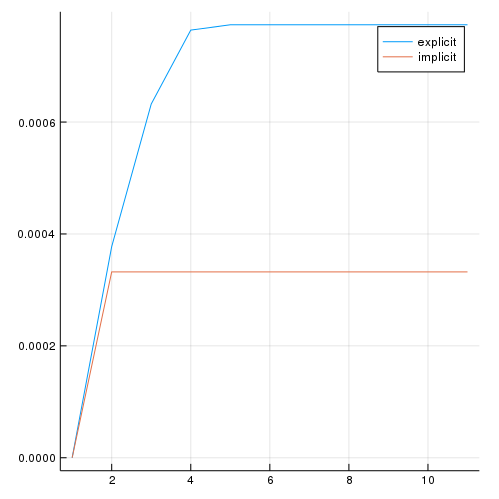

In [17]:
ts = cumsum([Δt for i in 1:N]);
j = 5
plot(traj_exp[j,:],label="explicit")
plot!(traj_imp[j,:],label="implicit")